In [1]:
# imports pytorch
import torch


XLA_USE_BF16=1

In [2]:
import time
import pandas as pd
import seaborn as sns
from IPython.display import Image, display
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image as Img
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.datasets.utils import download_url
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import torch.backends
import zipfile
torch.backends.cudnn.enabled = False
#CUDA_LAUNCH_BLOCKING=1.

# Nueva sección

In [3]:
dataset_url = r"https://challenges-asset-files.s3.us-east-2.amazonaws.com/Events/Oracle+Liga+Uni/1r+Reto/1st_oracle_challenge.zip"

# Descargar dataset si no existe
if not os.path.exists(r"./dataset"):
    print(">>>Descargando Datos")
    download_url(dataset_url, r"./dataset", "data.zip")
    with zipfile.ZipFile(r"./dataset/data.zip") as zip_dataset:
        print(">>>Descomprimiendo Dataset")
        zip_dataset.extractall(r"./dataset")
    os.remove(r"./dataset/data.zip")
    os.rename("./dataset/imgs","./dataset/all_imgs")

dataset_folder_path: str = r"./dataset"
train_set_path: str = r"./dataset/train.csv"
test_set_path: str = r"./dataset/test_no_label.csv"

In [4]:

archivo_train = r"./dataset/train.csv"
archivo_test = r"./dataset/test_no_label.csv"
dir_imagenes = r"./dataset/all_imgs/"

torch.cuda.max_memory_allocated(0)

0

In [5]:

dataset : pd.DataFrame = pd.read_csv(archivo_train, index_col=0)

In [6]:
print(dataset.head())

                                                    path_img  label
idx_train                                                          
0          all_imgs/bc7696f4-1460-4d0b-a63d-f84b3be4da0f....      0
1          all_imgs/f8d50663-60d8-4da5-a8b8-79f954aec503....      2
2          all_imgs/51df0f29-758b-4741-ab74-a0ff8e21c044....      4
3          all_imgs/f61b81d3-3b79-4162-b4d6-4f1b39518c4c....      0
4          all_imgs/b21e0668-bd09-4794-9e90-da8ecffc4c1c....      0


In [7]:
# Estratificar los dataset para que comprenda todas las clases por igual.
train_dataset, val_dataset = train_test_split(
    dataset, test_size=0.3, random_state=17)

In [8]:
dataset[:1]

,path_img,label
idx_train,,
0,all_imgs/bc7696f4-1460-4d0b-a63d-f84b3be4da0f....,0


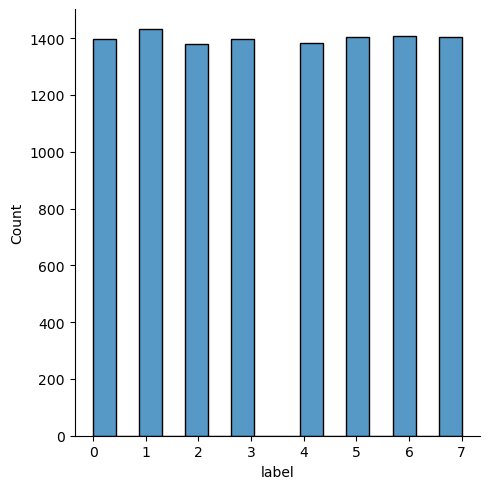

In [9]:
sns.displot(dataset.label)

In [10]:
torch.manual_seed(17)

In [11]:
class ComidasDataset(Dataset):
    def __init__(self, annotations_file : pd.DataFrame, transform=None, target_transform=None):
        self.img_labels = annotations_file
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = self.img_labels.iloc[idx, 0]
        img_path = dir_imagenes + os.path.basename(img_path)
        image = Img.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [12]:
transform = transforms.Compose([
    transforms.Resize(size=(400,400)),
    transforms.RandomResizedCrop(300),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip()
])

In [13]:
dat_train = ComidasDataset( train_dataset, transform=transform )
dat_test = ComidasDataset( val_dataset, transform=transform )

In [14]:
""" Muy importante:
    Aqui se decide el batch size, que despues se incluye en la capa lineal
"""
train_dataloader = DataLoader(dat_train, batch_size=10, shuffle=True)
test_dataloader = DataLoader(dat_test, batch_size=10, shuffle=True)

In [15]:
# base de rnn sacada de https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model


# Define a convolution neural network
# Variotanal autoencoder ?
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # se han usadp kernels de 3x3 para no complicar los calculos de dimensiones
        
        # in_channes = 3 colores (RGB)
        # out_channes = salidad de la convolucion (3*4)? 
        # kernes_size = tamaño de la cuadricula de convolucion
        # stride = pasos que se mueve la convolucion
        # padding = bode generado para no perder features en los extremos
        # Sacal un featuremap de 12 canales: [batchx12x512x512}
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(12)

        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(12)
        # max pool reduce las dimensiones del featuremp
        # salida = [batchx12x64x64]
        self.pool = nn.MaxPool2d(2, 2)

        # salida = [batchx24x64x64]
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        
        # salida = [batchx24x64x64]
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)

        #test, no se usa en el resultado
        self.flat = nn.Flatten()

        self.fc2 = nn.Linear(24*150*150, 128)
        self.fc1 = nn.Linear(128, 8)
        
        
        
    def forward(self, input):
        # fase 1 se pasa el output de la convolucion a BatchNorm y a ReLu
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(output)
        output = F.relu(self.bn4(self.conv4(output)))
        output = F.relu(self.bn5(self.conv5(output)))
        #print(output.size())
        output = output.view(-1, 24*150*150)
        #print(output.size())
        output = self.fc2(output)
        output = self.fc1(output)
        return output


# Instantiate a neural network model 
model = Network()

In [16]:
device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}: --> {torch.cuda.get_device_name(device)} device")

Using cuda:0: --> NVIDIA GeForce RTX 3050 Ti Laptop GPU device


In [17]:
# Funciones base sacadas de https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_loop(dataloader, model, loss_fn, optimizer):
    best_accuracy = 0.0
    
    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = xm.xla_device()
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model = model.to(device)
    size = len(dataloader.dataset)

    for batch, (images, label) in enumerate(dataloader):
        # get the inputs
        #X = Variable(torch.tensor(images))
        images = images.to(device)
        y = Variable(label.to(device))

        # Compute prediction and loss
        pred = model(images)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(batch)
        # print cada 2 batches = 2 * 1024 = 2048 imagenes
        if batch % 5 == 0:
            loss, current = loss.item(), (batch + 1) * len(images)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # device = xm.xla_device()

    # matriz de confusion
    y_pred = []
    y_true = []


    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            '''
            output = (torch.max(torch.exp(pred), 1)[1]).data.cpu().numpy()

            y_pred.extend(output) # Save Prediction
        
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) # Save Truth
            '''
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    '''
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion")
    print(conf_matrix)
    '''

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
# model.load_state_dict(torch.load(drive+f"model_13896134932304.pth"))

print(f"Utilizando: {torch.cuda.get_device_name(torch.cuda.current_device())}")
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))

Utilizando: NVIDIA GeForce RTX 3050 Ti Laptop GPU
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from l

In [19]:
from torch.optim import Adam

learning_rate = 0.0001 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
    if t+1 % 10 == 0:
      torch.save(model.state_dict(), f"./models/model_{time.monotonic_ns()}.pth")
print("Done!")

Epoch 1
-------------------------------
The model will be running on cuda:0 device
loss: 2.030154  [   10/ 7840]
loss: 4806.704590  [   60/ 7840]
loss: 1416.851318  [  110/ 7840]
loss: 3139.115967  [  160/ 7840]
loss: 1082.087158  [  210/ 7840]
loss: 688.424316  [  260/ 7840]
loss: 647.390259  [  310/ 7840]
loss: 397.007385  [  360/ 7840]
loss: 328.859192  [  410/ 7840]
loss: 192.521210  [  460/ 7840]
loss: 152.413574  [  510/ 7840]
loss: 161.308563  [  560/ 7840]
loss: 150.582397  [  610/ 7840]
loss: 72.196426  [  660/ 7840]
loss: 67.618210  [  710/ 7840]
loss: 54.287666  [  760/ 7840]
loss: 35.813454  [  810/ 7840]
loss: 51.015305  [  860/ 7840]
loss: 47.179546  [  910/ 7840]
loss: 19.436604  [  960/ 7840]
loss: 30.273865  [ 1010/ 7840]
loss: 25.021097  [ 1060/ 7840]
loss: 37.751823  [ 1110/ 7840]
loss: 12.527838  [ 1160/ 7840]
loss: 10.499110  [ 1210/ 7840]
loss: 15.675984  [ 1260/ 7840]
loss: 5.272470  [ 1310/ 7840]
loss: 3.850621  [ 1360/ 7840]
loss: 7.084550  [ 1410/ 7840]
loss: 

c:\Users\mario\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


loss: 3.310760  [ 2310/ 7840]
loss: 3.787205  [ 2360/ 7840]
loss: 2.965176  [ 2410/ 7840]
loss: 4.237495  [ 2460/ 7840]
loss: 2.619063  [ 2510/ 7840]
loss: 2.376907  [ 2560/ 7840]
loss: 3.495225  [ 2610/ 7840]
loss: 2.427114  [ 2660/ 7840]
loss: 3.457490  [ 2710/ 7840]
loss: 2.736624  [ 2760/ 7840]
loss: 2.149031  [ 2810/ 7840]
loss: 3.082492  [ 2860/ 7840]
loss: 2.041179  [ 2910/ 7840]
loss: 2.895219  [ 2960/ 7840]
loss: 2.406996  [ 3010/ 7840]
loss: 2.006307  [ 3060/ 7840]
loss: 2.008457  [ 3110/ 7840]
loss: 2.370728  [ 3160/ 7840]
loss: 1.873268  [ 3210/ 7840]
loss: 3.611030  [ 3260/ 7840]
loss: 2.118443  [ 3310/ 7840]
loss: 2.697916  [ 3360/ 7840]
loss: 2.102488  [ 3410/ 7840]
loss: 2.157150  [ 3460/ 7840]
loss: 2.411765  [ 3510/ 7840]
loss: 2.092116  [ 3560/ 7840]
loss: 2.038020  [ 3610/ 7840]
loss: 2.013723  [ 3660/ 7840]
loss: 2.203525  [ 3710/ 7840]
loss: 2.738631  [ 3760/ 7840]
loss: 1.943472  [ 3810/ 7840]
loss: 2.155337  [ 3860/ 7840]
loss: 2.171394  [ 3910/ 7840]
loss: 1.92

KeyboardInterrupt: 

In [ ]:
#@title Give me a name {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

In [ ]:
torch.cuda.empty_cache() # PyTorch thing

In [ ]:
import gc
gc.collect() # Python thing

In [ ]:
model = Network()
model.load_state_dict(torch.load(f"./models/model_3456965530940.pth"))

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_dataloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)